-----
## Predicting Global Supply Chain Outcomes for Essential HIV Medicines using Machine Learning Methods
------

### Author: Tichakunda Mangono

### **Capstone Project, Udacity Machine Learning Engineer Nanodegree, September 2017**



- ***Key Question:*** *Can we use procurement transaction data to predict whether a delivery is delayed and estimating the length of the delay*
- ***Main Data Source:*** *From The Website: https://data.pepfar.net/additionalData. Procurement transaction data from the Supply Chain Management System (SCMS), administered by the United States Agency for International Development (USAID), provides information on health commodities, prices, and delivery destinations.*

# Notebook 1: Data Cleaning & Feature Engineering

----
## 1. Data Cleaning
----

### Import the relevant libraries

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import my_helper_functions as mhf
import pandas_profiling as prof
import missingno as msno
%matplotlib inline

### Load the data files

In [2]:
# Data Source: https://data.pepfar.net/additionalData, downloaded as excel file
full = pd.ExcelFile('./Data/Source/SCMS Data 20151023.xlsx')
print("Sheetnames: ",full.sheet_names)
parsed_data = mhf.parse_raw_data(full)
for df in parsed_data:
    print(df.name," shape:",df.shape )

# View ref top rows
summary, purpose, ref, data = parsed_data
data.head(3)

Sheetnames:  ['Summary ', 'Data Purpose and Notes', 'Data Dictionary', 'SCMS Delivery History Dataset']
summary  shape: (0, 0)
purpose  shape: (0, 0)
ref  shape: (33, 5)
data  shape: (10324, 33)


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.0,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.2,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.0,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN


### Check Duplicates

In [3]:
data.duplicated().sum()

0

### Rename the columns

In [4]:
newcol_list = ['id', 'proj_code', 'pq_no', 'po_no', 'ship_no', 'country'
     , 'mngr', 'fulfill_via','vendor_terms', 'ship_mode', 'pq_date'
     , 'po_date', 'del_date_scheduled' ,'del_date_client', 'del_date_recorded'
     , 'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand'
     , 'dosage','dosage_form', 'units', 'ln_itm_qty', 'ln_itm_val', 'pk_price'
     , 'unit_price', 'factory', 'first_line', 'weight', 'freight_cost', 'line_itm_ins']
data = mhf.rename_data_columns(data, newcol_list)

Old columns:  Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')
New columns:  Index(['id', 'proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'del_date_scheduled', 'del_date_client', 'del_date_recorded',
       'prod_grp', 'sub_class', 'vendor', 'itm_

### Update Data Reference Dictionary

In [5]:
# Add these new columns to reference and make a lookup function in case we forget what it means
ref['NewColumn']= data.columns 
#ref.to_excel("Reference.xlsx") # save to disk
# Example usage of the reference function below:
mhf.getReferenceInfo(data, data.columns[5], ref)

5    Country
Name: FieldName, dtype: object 
, 5    Text
Name: DataType, dtype: object 
, 5    Destination country
Name: FieldDescription, dtype: object 
, 5    NaN
Name: FieldNotes, dtype: object 
          Examples: 
0    Côte d'Ivoire
1          Vietnam
2    Côte d'Ivoire
3          Vietnam
4          Vietnam
Name: country, dtype: object 



### Convert columns data types

In [6]:
# First use helper function to get column report and blocks of data by column type
blocks = mhf.get_blocks_by_dtype(data)

Total Number of Columns: 33
Breakdown....

Type: float64 , Count: 4 
Columns and null counts---: 
ln_itm_val        0
pk_price          0
unit_price        0
line_itm_ins    287
dtype: int64

Type: int64 , Count: 3 
Columns and null counts---: 
id            0
units         0
ln_itm_qty    0
dtype: int64

Type: datetime64[ns] , Count: 3 
Columns and null counts---: 
del_date_scheduled    0
del_date_client       0
del_date_recorded     0
dtype: int64

Type: object , Count: 23 
Columns and null counts---: 
proj_code           0
pq_no               0
po_no               0
ship_no             0
country             0
mngr                0
fulfill_via         0
vendor_terms        0
ship_mode         360
pq_date             0
po_date             0
prod_grp            0
sub_class           0
vendor              0
itm_desc            0
molecule_test       0
brand               0
dosage           1736
dosage_form         0
factory             0
first_line          0
weight              0
freigh

In [7]:
blocks.keys()

dict_keys(['float64', 'int64', 'datetime64[ns]', 'object'])

In [8]:
dfloat, dint, ddate, dobject = [d for d in blocks.values()]
print(dfloat.shape, dint.shape, ddate.shape, dobject.shape)

(10324, 4) (10324, 3) (10324, 3) (10324, 23)


### Investigate Missing Values

The previous section revealed some null values in a few columns

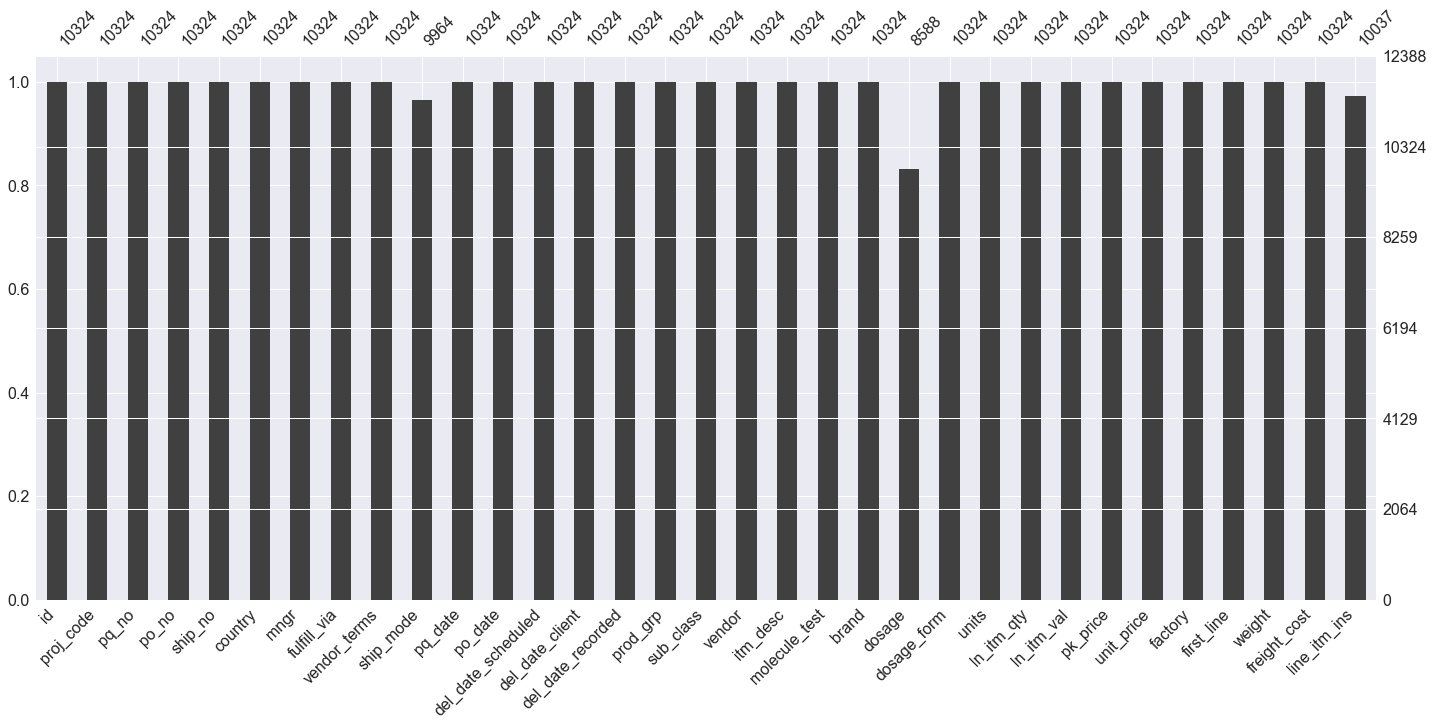

In [9]:
msno.bar(data, labels=True)

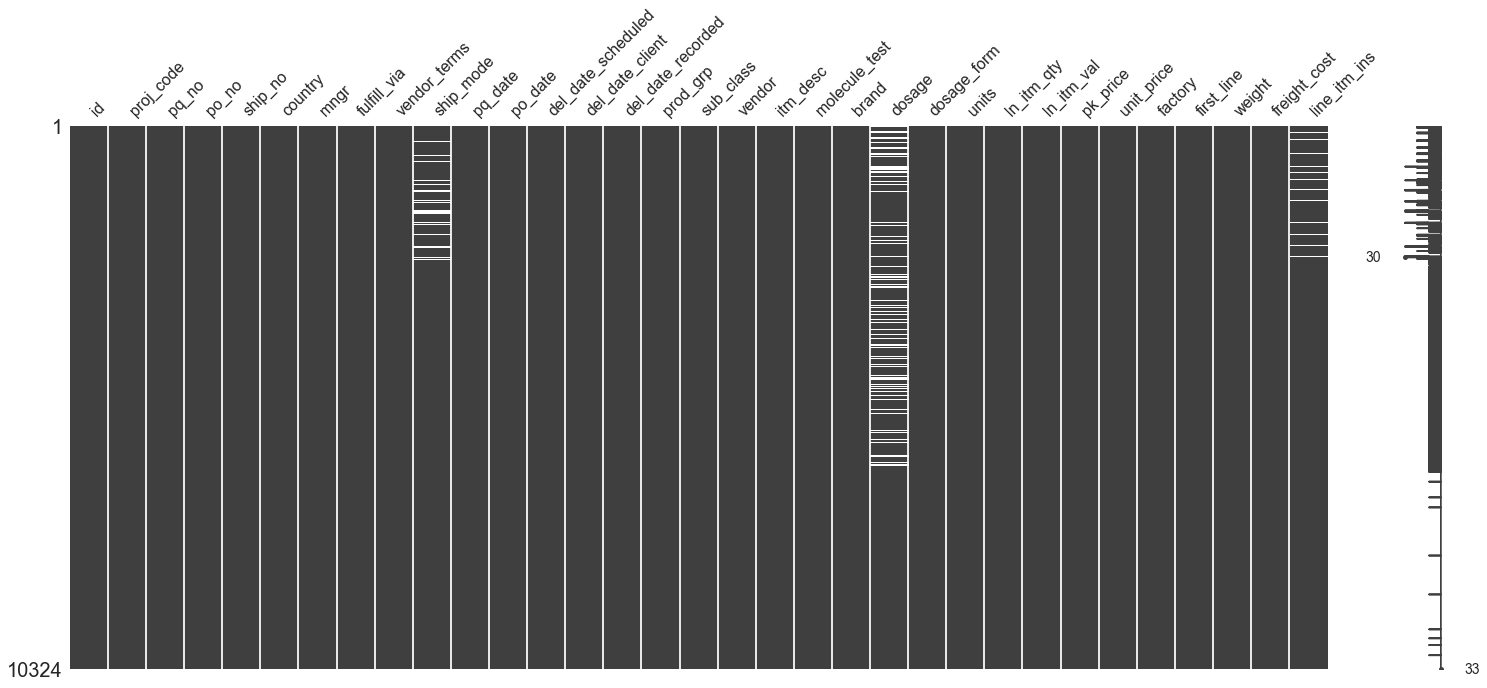

In [10]:
msno.matrix(data)

#### Missing value findings
From above, we can see that:

    -Dosage has a significant number of missing values
    - Line item Insurance and shipping mode have similarly moderate levels of missing values

####  Dosage

In [11]:
#### Fix the missing values for the dosage feature
# Dosage has a lot of missing values
dosage_nulls = dobject[dobject.dosage.isnull()]
# dosage_nulls.to_excel("Dosage_Nulls.xlsx")
# Excel investigation: Corelated with country, item_desc (Mostly HIV rapid test kits), molecule test
#, vendor_terms (EXnW??), fulfill_via (by air), Brand, dosage_form, units?# pk_price, factory
dosage_lkup = dobject[[ 'itm_desc', 'molecule_test', 'brand', 'dosage_form', 'dosage' ]].groupby(
[ 'itm_desc', 'molecule_test', 'brand','dosage_form']).max()
# Realize they are all test kits, 
dosage_lkup[dosage_lkup.dosage.isnull()].reset_index().dosage_form.value_counts()

Test kit                37
Test kit - Ancillary     9
Name: dosage_form, dtype: int64

In [12]:
def data_fill_na(data, column, fillvalue):
    print("Before: \n:", data.isnull().sum()[data.isnull().sum()>0])
    # So use NA-TestKit/Ancillary as dosage value
    data[column].fillna(value=fillvalue, inplace=True)
    # Check the nulls once again, these should be mainly from the date columns
    print("---\nAfter: \n:", data.isnull().sum()[data.isnull().sum()>0])
    return data    

In [13]:
dobject = data_fill_na(dobject, 'dosage', 'TestKit/Ancillary')

Before: 
: ship_mode     360
dosage       1736
dtype: int64
---
After: 
: ship_mode    360
dtype: int64


In [14]:
#### Fix the missing values for the dosage feature
# Dosage has a lot of missing values
def describe_nulls(data, column):
    nulls = data[data[column].isnull()]
    #nulls.to_excel(column+"_nulls.xlsx")
    for col in nulls:
        #print('\n',col,"nulls summary: \nCount: {} \nUnique: {} \nTop Freq: {}".format(col.count()
        #      ,len(col.unique()), col.values_count()[:3]))
        print('\n-------\n',nulls[col].describe())

#### Shipping Mode

In [15]:
describe_nulls(dobject, 'ship_mode')


-------
 count            360
unique            15
top       110-ZM-T01
freq              99
Name: proj_code, dtype: object

-------
 count                360
unique                 1
top       Pre-PQ Process
freq                 360
Name: pq_no, dtype: object

-------
 count            360
unique           220
top       SCMS-16600
freq              18
Name: po_no, dtype: object

-------
 count          360
unique         226
top       ASN-1520
freq            16
Name: ship_no, dtype: object

-------
 count               360
unique               12
top       Côte d'Ivoire
freq                113
Name: country, dtype: object

-------
 count          360
unique           1
top       PMO - US
freq           360
Name: mngr, dtype: object

-------
 count          360
unique           2
top       From RDC
freq           312
Name: fulfill_via, dtype: object

-------
 count                360
unique                 5
top       N/A - From RDC
freq                 312
Name: vendor_terms, dtype:

In [16]:
data, column, groupby = [dobject.copy(), 'ship_mode',['country', 'itm_desc', 'ship_mode']]
# make cx
cx=data.groupby(groupby).agg('count').reset_index()[['country', 'itm_desc', 'ship_mode']]
print(cx.shape, cx.columns)
cx = cx.groupby(['country', 'itm_desc']).min().reset_index()
# make cy
cy = pd.merge(data, cx, how='left', left_on=['country', 'itm_desc']
         , right_on=['country', 'itm_desc'], suffixes=('','_y'))
print(cy.shape, cy.columns)
# assign
cy['ship_mode'] = cy.ship_mode.where(cy.ship_mode.notnull(), cy.ship_mode_y)
still_null= cy.ship_mode.isnull().index # find remiaining nulls
a = data.ship_mode.value_counts()/data.ship_mode.value_counts().sum() # values distributed randomness 
for j in still_null:
    cy.loc[j,'ship_mode'] = np.random.choice([i for i in a.index], p=[v for v in a])
cy.ship_mode.isnull().sum()
# Drop
cy.drop('ship_mode_y', axis=1, inplace=True)
print(cy.shape)
dobject= cy.copy()

(1323, 3) Index(['country', 'itm_desc', 'ship_mode'], dtype='object')
(10324, 24) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'ship_mode_y'],
      dtype='object')
(10324, 23)


#### Line Item Insurance

In [17]:
dfloat.isnull().sum()

ln_itm_val        0
pk_price          0
unit_price        0
line_itm_ins    287
dtype: int64

In [18]:
yr = pd.Series([str(x).split("-")[0] for x in ddate.del_date_scheduled], index = ddate.del_date_scheduled.index)
d_ins = dobject[dfloat.line_itm_ins.isnull()]
#d_ins.to_excel('line_insurance_missing_values.xlsx')
# Most missing values driven by 2007 items, so use lower end of 2007 insurance
# Use Median Value
q1 = np.percentile(dfloat[yr == '2007'].dropna()['line_itm_ins'], 0.5)
dfloat.fillna(value=q1, inplace=True)
q1

0.0024500000000000012

### Investigate Misclassified/Misplaced Features
#### e.g. dates cast as objects etc.


#### Purchase Quotation and Purchase Order Dates 

**Pull out the meanings and definitions:**

- **"Pre-PQ Process"** indicates deliveries that occurred before the PQ process was put in place in mid-2009.  

- **"Date Not Captured"** where date was not captured.

- Not applicable for from RDC deliveries (**"NA - From RDC"**).  RDC means Regional Delivery Center

- **"Date Not Captured"** where date was not captured.

Given the information above, let's try the following mapping

- Pre-PQ Process : 12-31-2008, OR Fill in these based on other time columns?
- Date Not Captured: NaT
- NA - From RDC : A month before scheduled delivery, if available? OR Fill in these based on other time columns?
- Date Not Captured: NaT

First try this though...
- Pre-PQ Process : 1-1-1970 or pd.to_datetime(0)
- Date Not Captured: NaT
- NA - From RDC : 1-1-1970 or pd.to_datetime(0)
- Date Not Captured: NaT
 

In [19]:
# Check columns of interest
dobject[['pq_date', 'po_date']].describe()

,pq_date,po_date
count,10324,10324
unique,765,897
top,Pre-PQ Process,N/A - From RDC
freq,2476,5404


In [20]:
dobject.info() # Notice pq_date and po_date should be datetime type but currently classified as object columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 23 columns):
proj_code        10324 non-null object
pq_no            10324 non-null object
po_no            10324 non-null object
ship_no          10324 non-null object
country          10324 non-null object
mngr             10324 non-null object
fulfill_via      10324 non-null object
vendor_terms     10324 non-null object
ship_mode        10324 non-null object
pq_date          10324 non-null object
po_date          10324 non-null object
prod_grp         10324 non-null object
sub_class        10324 non-null object
vendor           10324 non-null object
itm_desc         10324 non-null object
molecule_test    10324 non-null object
brand            10324 non-null object
dosage           10324 non-null object
dosage_form      10324 non-null object
factory          10324 non-null object
first_line       10324 non-null object
weight           10324 non-null object
freight_cost     10324 non-null o

In [21]:
# We see that pq_date and po_date have some non-date values
for c  in ['po_date', 'pq_date']:
    print("-----\nNon-datetime entries for {}: {}".format(c,
        [x for x in dobject[c].unique() if type(x) == str]))

-----
Non-datetime entries for po_date: ['Date Not Captured', 'N/A - From RDC']
-----
Non-datetime entries for pq_date: ['Pre-PQ Process', 'Date Not Captured']


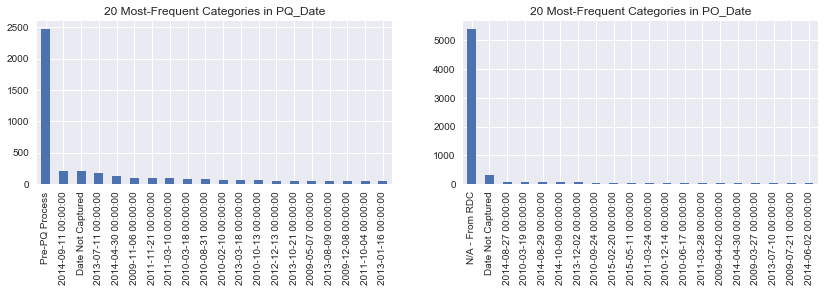

In [22]:
# Investigate the size of these string descriptions, we see they are quite significant. 
# Date not Captured is noticeable but not a lot, more investigation...
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
data['pq_date'].value_counts()[:20].plot(kind='bar', ax=ax1)
ax1.set_title("20 Most-Frequent Categories in PQ_Date")
data['po_date'].value_counts()[:20].plot(kind='bar', ax=ax2)
ax2.set_title("20 Most-Frequent Categories in PO_Date")

In [23]:
# Let's take this outside..to excel
po_idx = dobject[(dobject.po_date=='Date Not Captured')|(dobject.po_date=="N/A - From RDC")].index        
pq_idx = dobject[(dobject.pq_date=='Pre-PQ Process') | (dobject.pq_date=='Date Not Captured')].index
dnc_idx = list(po_idx) + list(pq_idx)

#dobject.loc[dnc_idx,:].to_excel("po_pq_date_not_captured.xlsx")
#ddate.loc[dnc_idx,:].to_excel('po_pq_date_not_captured_comp.xlsx')

# For South Africa, We find 2 project codes that are responsible..and a few countries too
dobject[(dobject.proj_code=='116-ZA-T30')
| (dobject.proj_code =='116-ZA-T01')].to_excel('po_pq_date_not_captured_ref.xlsx')

dnc_proj_idx = list(dobject[(dobject.proj_code=='116-ZA-T30')
| (dobject.proj_code =='116-ZA-T01')].index)
ddate.loc[dnc_proj_idx,:].to_excel('po_pq_date_not_captured_comp_proj.xlsx')

In [24]:
print(len(po_idx), len(pq_idx), len(dnc_idx))

5732 2681 8413


In [25]:
data, column, groupby = [dobject.copy(), 'po_date',['country', 'Itm_desc','del_date_scheduled','po_date']]
#ddate.del_date_scheduled[dnc_idx] - pd.to_datetime(dobject.po_date[dnc_idx])
dx = pd.merge(dobject, ddate, how='left', left_index=True, right_index=True)
dx.po_date.replace({'Date Not Captured':pd.to_datetime('1900')
                    , 'N/A - From RDC':pd.to_datetime('1910')}, inplace=True)
dx.pq_date.replace({'Date Not Captured':pd.to_datetime('1970')
                    , 'Pre-PQ Process':pd.to_datetime('1980'),}, inplace=True)
dx['po_date_est'] = dx.del_date_scheduled - pd.to_datetime(dx.po_date)
dx['pq_date_est'] = pd.to_datetime(dx.po_date) - pd.to_datetime(dx.pq_date)

#### Replace strings with dummy dates, estimate days from purchase order to scheduled delivery

In [26]:
## Make Sandbox...
dd , do = ddate.copy(),dobject.copy()
do.po_date.replace({'Date Not Captured':pd.to_datetime('1900')
                    , 'N/A - From RDC':pd.to_datetime('1910')}, inplace=True)
do.pq_date.replace({'Date Not Captured':pd.to_datetime('1970')
                    , 'Pre-PQ Process':pd.to_datetime('1980'),}, inplace=True)
print(dd.shape, do.shape)
for col in ['pq_date', 'po_date']:
    dd[col] = pd.to_datetime(do[col])
    do.drop(col, axis=1, inplace=True)
print(dd.shape, do.shape)
dd.head()
# do conversions...
estdates =['pq_date','po_date'] 
time_factor = 1e9*3600*24.0
for c in estdates:
    dd[c+"_est"] = pd.to_numeric(dd['del_date_scheduled'] - dd[c])/(time_factor)
print("\n Describe..",dd.describe())

(10324, 3) (10324, 23)
(10324, 5) (10324, 21)

 Describe..         pq_date_est   po_date_est
count  10324.000000  10324.000000
mean    2906.575746  20701.253003
std     4653.136085  18453.240587
min     -150.000000   -160.000000
25%      127.000000    105.750000
50%      196.000000  35809.000000
75%     9914.000000  37337.000000
max    14663.000000  41378.000000


In [27]:
# Make seperate indices
fillvals = ['1900', '1910', '1970', '1980']
po_dnc_i, po_rdc_i  = list(dd[dd.po_date==fillvals[0]].index), list(dd[dd.po_date==fillvals[1]].index)
pq_dnc_i,pq_pqp_i = list(dd[dd.pq_date==fillvals[2]].index),list(dd[dd.pq_date==fillvals[3]].index)
print("Length PO troublesome indices: ",len(set(po_dnc_i+po_rdc_i)))
print("Length PQ troublesome indices: ",len(set(pq_dnc_i+pq_pqp_i)))
# Merge with country vendor then add year variable
dd = pd.merge(dd, do[['country', 'vendor', 'itm_desc']], how="left", right_index=True, left_index=True)
dd['year'] = [x.year for x in dd.del_date_scheduled]
print(dd.columns)

Length PO troublesome indices:  5732
Length PQ troublesome indices:  2681
Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'pq_date_est', 'po_date_est', 'country', 'vendor',
       'itm_desc', 'year'],
      dtype='object')


#### Make Purchase order date (po_date)  lookup dataframe and merge

In [28]:
# Make lookup tables with alternate FillValues (summary stats) 
print("\nBegin mean: ", dd.mean())
# drop the problem items first  in the right order then aggregate at right level
dd_trim= dd.drop(po_dnc_i + po_rdc_i, axis=0)
print("\nEnd mean: ",dd_trim.mean())
# Make lookup tables for po
po_lkup = dd_trim.groupby(['country','year']).agg('mean').reset_index()
po_lkup_yr = dd_trim.groupby(['year']).agg('mean').reset_index()
print("\Lookup table columns: ",po_lkup.columns,po_lkup_yr.columns)
# Now merge with original dd, not dd_trim..
#del tst;del tst2
# Merge with more detailed averages, country-year level
print(dd.loc[po_rdc_i + po_dnc_i,'po_date'].value_counts()[:10])
tst =pd.merge(dd, po_lkup, left_on=['country','year'],
        right_on=['country', 'year'], how='left')
print("\nNulls remaining: ",tst['po_date_est_y'].isnull().sum())
# # Merge with less detailed averages, year level
tst2 =pd.merge(tst, po_lkup_yr, left_on=['year'],
        right_on=['year'], how='left')
print("\nNulls remaining: ",tst2['po_date_est'].isnull().sum())
print(tst2[['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'pq_date_est_x','po_date_est_x','pq_date_est_y','po_date_est_y',
            'pq_date_est','po_date_est']].head())
dd = tst2[['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'pq_date_est_x','po_date_est_x','pq_date_est_y','po_date_est_y',
            'pq_date_est','po_date_est']]


Begin mean:  pq_date_est     2906.575746
po_date_est    20701.253003
year            2011.257555
dtype: float64

End mean:  pq_date_est    1851.457753
po_date_est     105.742596
year           2011.851699
dtype: float64
\Lookup table columns:  Index(['country', 'year', 'pq_date_est', 'po_date_est'], dtype='object') Index(['year', 'pq_date_est', 'po_date_est'], dtype='object')
1910-01-01    5404
1900-01-01     328
Name: po_date, dtype: int64

Nulls remaining:  153

Nulls remaining:  0
  del_date_scheduled del_date_client del_date_recorded    pq_date    po_date  \
0         2006-06-02      2006-06-02        2006-06-02 1980-01-01 1900-01-01   
1         2006-11-14      2006-11-14        2006-11-14 1980-01-01 1900-01-01   
2         2006-08-27      2006-08-27        2006-08-27 1980-01-01 1900-01-01   
3         2006-09-01      2006-09-01        2006-09-01 1980-01-01 1900-01-01   
4         2006-08-11      2006-08-11        2006-08-11 1980-01-01 1900-01-01   

   pq_date_est_x  po_date_est

#### Purchase Order Dates - New Estimates 

In [29]:
###### Estimate PO DATE using fill values and conditional logic on df ##########
# Merge the columns into one first and second
dd['po_datediff'] = dd.po_date_est_x
print("---\nTotal  obs: {}, \nFrom _X: {}, \nFrom _Y: {}, Still Null: {}".format(
    len(dd.po_datediff), sum(dd.po_datediff==dd.po_date_est_x)
      , sum(dd.po_datediff==dd.po_date_est_y), dd.po_datediff.isnull().sum()))
m1 = dd.po_datediff < 2000
dd['po_datediff'].where(m1,dd.po_date_est_y,inplace=True)
print("---\nTotal  obs: {}, \nFrom _X: {}, \nFrom _Y: {}, Still Null: {}".format(
    len(dd.po_datediff), sum(dd.po_datediff==dd.po_date_est_x)
      , sum(dd.po_datediff==dd.po_date_est_y), dd.po_datediff.isnull().sum()))
# DEal with the remaining nulls
print('Mean for PO DaTE: ',dd.po_datediff.mean())
m2 = dd.po_datediff.notnull()
dd['po_datediff'].where(m2,dd.po_date_est,inplace=True)
print("---\nTotal  obs: {}, \nFrom _Y: {}, Still Null: {}".format(
    len(dd.po_datediff), sum(dd.po_datediff==dd.po_date_est), dd.po_datediff.isnull().sum()))
print('Mean for PO DaTE: ',dd.po_datediff.mean())
## Calculating New PO Date, Finally!
dd['po_date_new'] = dd.del_date_scheduled-[pd.Timedelta(str(x)+" days") for x in dd.po_datediff]
print(dd.po_date_new.isnull().sum())

---
Total  obs: 10324, 
From _X: 10324, 
From _Y: 23, Still Null: 0
---
Total  obs: 10324, 
From _X: 4592, 
From _Y: 5602, Still Null: 153
Mean for PO DaTE:  104.24235249154053
---
Total  obs: 10324, 
From _Y: 153, Still Null: 0
Mean for PO DaTE:  103.79779573316473
0


#### Purchase Quote Dates - New Estimates 

In [30]:
###### PQ DATE is then derived from NEW PO DATE ########
# keep it simple i.e. what is the average podate pqdate diff without the problem areas?
dd['pq_datediff'] = dd.pq_date_est_x
pq_mean = dd.drop(pq_dnc_i+pq_pqp_i, axis=0)['pq_datediff'].mean()
print(dd.pq_date_est_x.mean())
print(pq_mean)
n1 = dd.pq_datediff < 2000
dd['pq_datediff'] = dd['pq_datediff'].where(n1,pq_mean)
dd['pq_date_new'] = dd.po_date_new -[pd.Timedelta(str(x)+" days") for x in dd.pq_datediff]
print(dd.mean())
ddate = dd[['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date','po_date_new', 'pq_date_new']]
ddate.columns

2906.5757458349476
172.24349077587334
pq_date_est_x     2906.575746
po_date_est_x    20701.253003
pq_date_est_y     2582.371079
po_date_est_y      104.242352
pq_date_est       2659.086700
po_date_est        102.549427
po_datediff        103.797796
pq_datediff        172.243491
dtype: float64


Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'po_date_new', 'pq_date_new'],
      dtype='object')

#### Weight and Freight Cost
#### The freight cost and weight columns should be either floats or ints 
#### But currently are misclassified as "object"

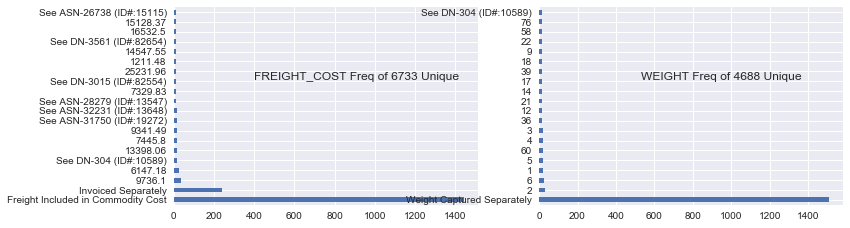

In [31]:
mhf.plotFreq(dobject, ['freight_cost', 'weight'], cutoff=20)

In [32]:
# Convert all numbers to floats, transform all numbers to numeric, deal strings later below...
fwcols = ['freight_cost','weight']
for c in fwcols:
    dobject[c]=dobject[c].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
    print("\nType Counts for: {}, \n{}".format(c,
        pd.Series([type(x) for x in dobject['freight_cost']]).value_counts()))


Type Counts for: freight_cost, 
<class 'float'>    5734
<class 'str'>      4126
<class 'int'>       464
dtype: int64

Type Counts for: weight, 
<class 'float'>    5734
<class 'str'>      4126
<class 'int'>       464
dtype: int64


#### Initial observations..
We can see a few things:

- for freight_cost 
    - about 1500 times the freight is included in the commodity cost
    - About 250 times the freight is invoiced separately
    - Several entries have a reference instead of amount. 
        - This reference can occurs many times, find out what it means..
    - The rest of the entries are numerical as expected: a mixture of integers and floats
- for weight: 
    - About 1500 times the weight was captured seperately
    - the rest are mostly integers
    
    ===========

- First Line Designation	
    - Designates if the line in question shows the aggregated freight costs and weight associated with all items on the ASN/DN .There may or may not be other associated lines with each ASN/DN
- Weight (Kilograms)
    - Weight for all lines on an ASN/DN	Present only for FirstLine designated lines
- Freight Cost (USD)
    - Freight charges associated with all lines on the respective ASN/DN	Present only for FirstLine designated lines. For C- and D-vendor INCO term deliveries, freight costs may be included in the unit price for the commodities as indicated by "Freight Included in Commodity Price". All other lines are "Invoiced Separately"

#### Get more insight into the freight and weight columns

In [33]:
for c in fwcols:
    print("\n---",c+"\n",dobject[c].apply(lambda x: x if type(x)== str else 1).value_counts()[:8])


--- freight_cost
 1                                     6198
Freight Included in Commodity Cost    1442
Invoiced Separately                    239
See DN-304 (ID#:10589)                  16
See ASN-32231 (ID#:13648)               14
See ASN-31750 (ID#:19272)               14
See ASN-28279 (ID#:13547)               13
See DN-3015 (ID#:82554)                 12
Name: freight_cost, dtype: int64

--- weight
 1                             6372
Weight Captured Separately    1507
See DN-304 (ID#:10589)          16
See ASN-31750 (ID#:19272)       14
See ASN-32231 (ID#:13648)       14
See ASN-28279 (ID#:13547)       13
See DN-3015 (ID#:82554)         12
See ASN-26738 (ID#:15115)       10
Name: weight, dtype: int64


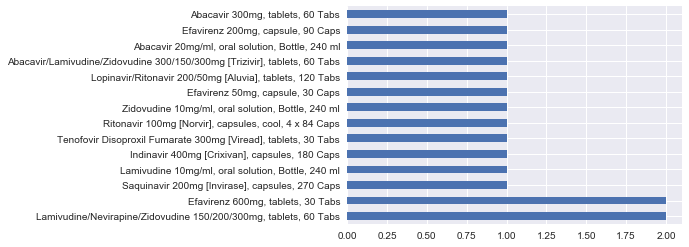

In [34]:
# Let's see an example for weight
dobject[dobject['weight'] == 'See DN-304 (ID#:10589)']['itm_desc'].value_counts().plot(
    kind='barh')

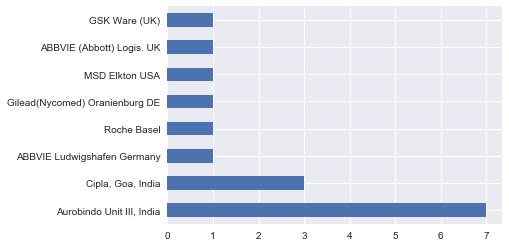

In [35]:
# Let's see an example for weight
dobject[dobject['weight'] == 'See DN-304 (ID#:10589)']['factory'].value_counts().plot(
    kind='barh')

In [36]:
# This is the top line item with the weight data for all the ones above..
# Weight is bundled/consolidated
print("/n Weight: ", dobject[dint['id']==10589].weight)

/n Weight:  1056    9006
Name: weight, dtype: object


In [37]:
# Let's see an example for freight cost
dobject[dobject['freight_cost'] == 'See ASN-31750 (ID#:19272)'].head()

,proj_code,pq_no,po_no,ship_no,country,mngr,fulfill_via,vendor_terms,ship_mode,pq_date,...,vendor,itm_desc,molecule_test,brand,dosage,dosage_form,factory,first_line,weight,freight_cost
3623,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Air,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4041,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Truck,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4057,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Truck,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4157,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Air,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4448,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Air,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)


In [38]:
# This is the top line item with the freight cost for all the ones above..
print(dobject[dint['id']==19272], "/nFreight Cost: ", dobject[dint['id']==19272].freight_cost)

       proj_code      pq_no        po_no    ship_no     country      mngr  \
3014  101-CD-T30  FPQ-16001  SCMS-280210  ASN-31750  Congo, DRC  PMO - US   

      fulfill_via vendor_terms ship_mode              pq_date     ...       \
3014  Direct Drop          EXW       Air  2015-03-10 00:00:00     ...        

                    vendor                             itm_desc  \
3014  Trinity Biotech, Plc  HIV 1/2, Uni-Gold HIV Kit, 20 Tests   

                  molecule_test     brand             dosage dosage_form  \
3014  HIV 1/2, Uni-Gold HIV Kit  Uni-Gold  TestKit/Ancillary    Test kit   

                   factory first_line weight freight_cost  
3014  Trinity Biotech, Plc        Yes    508      3918.37  

[1 rows x 23 columns] /nFreight Cost:  3014    3918.37
Name: freight_cost, dtype: object


In [39]:
# Save both of these to csv files for inspections!
# dobject[dint['id']==10589].to_csv("weight_ID10589.csv")
# dobject[dobject['weight'] == 'See DN-304 (ID#:10589)'].to_csv("weight_See DN-304 ID10589.csv")
# dobject[dint['id']==19272].to_csv("freightcost_ID19272.csv")
# dobject[dobject['freight_cost'] == 'See ASN-31750 (ID#:19272)'].to_csv("freightcost_See ASN-31750 ID19272.csv")

#### Weight - new estimates 

In [40]:
#Alternatively...use ship numbers to make dict
bundled_itms =dobject.groupby('ship_no').filter(lambda x: len(x)>1)
print("all bundled : ", bundled_itms.shape)
unbundled_itms = dobject.groupby('ship_no').filter(lambda x: len(x)==1)
print("all unbundled: ",unbundled_itms.shape,"\n----\n")
print("Unbundled Items Top Freq: \n----\n {},Bundled Items Top Freq: \n----\n {} ".format(unbundled_itms.weight.value_counts()[:5]
,bundled_itms.weight.value_counts()[:5]))

all bundled :  (4744, 23)
all unbundled:  (5580, 23) 
----

Unbundled Items Top Freq: 
----
 Weight Captured Separately    465
2                              29
6                              24
1                              23
5                              20
Name: weight, dtype: int64,Bundled Items Top Freq: 
----
 Weight Captured Separately    1042
See DN-304 (ID#:10589)          16
See ASN-32231 (ID#:13648)       14
See ASN-31750 (ID#:19272)       14
See ASN-28279 (ID#:13547)       13
Name: weight, dtype: int64 


In [41]:
# Find those with weight captured separately
sep_weight_bundled = bundled_itms[bundled_itms.weight== 'Weight Captured Separately']
print("only bundled separate weight: ",sep_weight_bundled.shape)
sep_weight_single = unbundled_itms[unbundled_itms.weight== 'Weight Captured Separately']
print("only single separate weight: ",sep_weight_single.shape)

only bundled separate weight:  (1042, 23)
only single separate weight:  (465, 23)


In [42]:
# Seperate out the single, topline and bottom items..
single_itms = unbundled_itms.drop(list(sep_weight_single.index),axis=0)
print("only single: ",single_itms.shape)
bundled_no_sep_weight = bundled_itms.drop(list(sep_weight_bundled.index),axis=0)
top_itms = bundled_no_sep_weight[[type(x)==int for x in bundled_no_sep_weight.weight]]
print("only topline: ",top_itms.shape)
bottom_itms = bundled_no_sep_weight.drop(top_itms.index)
print("only bottom items :",bottom_itms.shape)

only single:  (5115, 23)
only topline:  (1257, 23)
only bottom items : (2445, 23)


In [43]:
# Check the math, should both equal 10234
print("Check, must both equal n=10234 \n---\n",top_itms.shape[0] + bottom_itms.shape[0] + single_itms.shape[0] + sep_weight_single.shape[0] + sep_weight_bundled.shape[0])
print(bundled_itms.shape[0] + unbundled_itms.shape[0])

Check, must both equal n=10234 
---
 10324
10324


#### Finally, merged with dataframe based on lookup table

#### Calculate Average Weight per Item

In [44]:
# Make weight lookup dictionary to cover all product item scenarios
w_lkup = single_itms[['itm_desc','weight','molecule_test', 'dosage_form']]
w_lkup['weight'] = pd.to_numeric(w_lkup.weight)
w_lkup['ln_itm_qty'] = dint.loc[list(w_lkup.index),:]['ln_itm_qty']
w_lkup['units'] = dint.loc[list(w_lkup.index),:]['units']
w_lkup['itm_weight'] = w_lkup.weight/w_lkup.ln_itm_qty
print(w_lkup.shape, w_lkup.columns)

# Make lookup tables for each case, in order..
w_lkup_itm = w_lkup.groupby('itm_desc').mean().reset_index()[['itm_desc', 'itm_weight']]
w_lkup_mol = w_lkup.groupby('molecule_test').mean().reset_index()[['molecule_test', 'itm_weight']]
w_lkup_dos = w_lkup.groupby('dosage_form').mean().reset_index()[['dosage_form', 'itm_weight']]

merge_itm = pd.merge(dobject, w_lkup_itm, how='left', left_on='itm_desc', right_on='itm_desc')
merge_mol = pd.merge(merge_itm, w_lkup_mol, how='left', left_on='molecule_test'
                     , right_on='molecule_test')
merge_dos = pd.merge(merge_mol, w_lkup_dos, how='left', left_on='dosage_form'
                     , right_on='dosage_form')
print(merge_itm.shape, merge_mol.shape, merge_dos.shape)

(5115, 7) Index(['itm_desc', 'weight', 'molecule_test', 'dosage_form', 'ln_itm_qty',
       'units', 'itm_weight'],
      dtype='object')
(10324, 24) (10324, 25) (10324, 26)


In [45]:
print(" Nulls at starting point: ", merge_dos.itm_weight_x.isnull().sum())
w1 = merge_dos.itm_weight_x.notnull()
merge_dos['itm_weight_new'] =merge_dos.itm_weight_x.where(w1
                                                                ,merge_dos.itm_weight_y)
print(" Nulls at midpoint...: ", merge_dos.itm_weight_new.isnull().sum())
w2 = merge_dos.itm_weight_new.notnull()
merge_dos['itm_weight_new'] = merge_dos.itm_weight_new.where(w2
                                                                ,merge_dos.itm_weight)
print(" Nulls at endpoint: ", merge_dos.itm_weight_new.isnull().sum())
dobject = merge_dos[['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost',
        #'itm_weight_x', 'itm_weight_y', 'itm_weight',
       'itm_weight_new']]

 Nulls at starting point:  241
 Nulls at midpoint...:  49
 Nulls at endpoint:  0


#### Calculate the real weight of items and move it to the float dictionary

In [46]:
dfloat['ln_itm_weight'] = dint['ln_itm_qty']*dobject['itm_weight_new']
# drop it in the dobject
dobject.drop(['itm_weight_new'
             # ,'weight'
             ], axis=1, inplace=True)
dfloat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 5 columns):
ln_itm_val       10324 non-null float64
pk_price         10324 non-null float64
unit_price       10324 non-null float64
line_itm_ins     10324 non-null float64
ln_itm_weight    10324 non-null float64
dtypes: float64(5)
memory usage: 403.4 KB


#### Freight Cost - new estimate

In [47]:
dobject.freight_cost.value_counts()[:5]

Freight Included in Commodity Cost    1442
Invoiced Separately                    239
9736.1                                  36
6147.18                                 27
See DN-304 (ID#:10589)                  16
Name: freight_cost, dtype: int64

In [48]:
# FC Invoiced Seperately
sep_freight_cost_bundled = bundled_itms[bundled_itms.freight_cost== 'Invoiced Separately']
print("only bundled separate freight_cost: ",sep_freight_cost_bundled.shape)
sep_freight_cost_single = unbundled_itms[unbundled_itms.freight_cost== 'Invoiced Separately']
print("only single separate freight_cost: ",sep_freight_cost_single.shape)
# FC Included in Commodity Costs
included_freight_cost_bundled = bundled_itms[bundled_itms.freight_cost== 'Freight Included in Commodity Cost']
print("only bundled freight_cost in commodity cost: ",included_freight_cost_bundled.shape)
included_freight_cost_single = unbundled_itms[unbundled_itms.freight_cost== 'Freight Included in Commodity Cost']
print("only single freight_cost in commodity cost: ",included_freight_cost_single.shape)

only bundled separate freight_cost:  (58, 23)
only single separate freight_cost:  (181, 23)
only bundled freight_cost in commodity cost:  (1000, 23)
only single freight_cost in commodity cost:  (442, 23)


In [49]:
single_itms.freight_cost.value_counts()[:3]

Freight Included in Commodity Cost    173
9736.1                                 35
6147.18                                27
Name: freight_cost, dtype: int64

In [50]:
top_itms.freight_cost.value_counts()[:3]

Freight Included in Commodity Cost    23
17090                                  6
7329.83                                4
Name: freight_cost, dtype: int64

In [51]:
bottom_itms.freight_cost.value_counts()[:3]

See DN-304 (ID#:10589)       16
See ASN-32231 (ID#:13648)    14
See ASN-31750 (ID#:19272)    14
Name: freight_cost, dtype: int64

In [52]:
# Seperate out the single, topline and bottom items..
single_itms_fc = single_itms.drop(list(
single_itms[single_itms.freight_cost=='Freight Included in Commodity Cost'].index),axis=0)
print("only single: ",single_itms_fc.shape)
top_itms_fc = top_itms.drop(list(
    top_itms[top_itms.freight_cost=='Freight Included in Commodity Cost'].index), axis=0)
print("only topline: ",top_itms_fc.shape)
bottom_itms_fc = bottom_itms
print("only bottom items :",bottom_itms_fc.shape)

only single:  (4942, 23)
only topline:  (1234, 23)
only bottom items : (2445, 23)


#### Finally, merged with dataframe based on lookup table

#### Calculate Average Freight_cost per Item **weight**

In [53]:
# Make freight_cost lookup dictionary to cover all product item scenarios
f_lkup = single_itms_fc[['itm_desc','freight_cost','molecule_test', 'dosage_form']]
f_lkup['freight_cost'] = pd.to_numeric(f_lkup.freight_cost)
f_lkup['ln_itm_weight'] = dfloat.loc[list(f_lkup.index),:]['ln_itm_weight']
f_lkup['itm_freight_cost'] = f_lkup.freight_cost/f_lkup.ln_itm_weight
print(f_lkup.shape, f_lkup.columns)
# Make lookup tables for each case, in order..
f_lkup_itm = f_lkup.groupby('itm_desc').mean().reset_index()[['itm_desc', 'itm_freight_cost']]
f_lkup_mol = f_lkup.groupby('molecule_test').mean().reset_index()[['molecule_test', 'itm_freight_cost']]
f_lkup_dos = f_lkup.groupby('dosage_form').mean().reset_index()[['dosage_form', 'itm_freight_cost']]
# Merge
fmerge_itm = pd.merge(dobject, f_lkup_itm, how='left', left_on='itm_desc', right_on='itm_desc')
fmerge_mol = pd.merge(fmerge_itm, f_lkup_mol, how='left', left_on='molecule_test'
                     , right_on='molecule_test')
fmerge_dos = pd.merge(fmerge_mol, f_lkup_dos, how='left', left_on='dosage_form'
                     , right_on='dosage_form')
print(fmerge_itm.shape, fmerge_mol.shape, fmerge_dos.shape)

(4942, 6) Index(['itm_desc', 'freight_cost', 'molecule_test', 'dosage_form',
       'ln_itm_weight', 'itm_freight_cost'],
      dtype='object')
(10324, 24) (10324, 25) (10324, 26)


In [54]:
print(" Nulls at starting point: ", fmerge_dos.itm_freight_cost_x.isnull().sum())
w1 = fmerge_dos.itm_freight_cost_x.notnull()
fmerge_dos['itm_freight_cost_new'] =fmerge_dos.itm_freight_cost_x.where(w1
                                                                ,fmerge_dos.itm_freight_cost_y)
print(" Nulls at midpoint...: ", fmerge_dos.itm_freight_cost_new.isnull().sum())
w2 = fmerge_dos.itm_freight_cost_new.notnull()
fmerge_dos['itm_freight_cost_new'] = fmerge_dos.itm_freight_cost_new.where(w2
                                                                ,fmerge_dos.itm_freight_cost)
print(" Nulls at endpoint: ", fmerge_dos.itm_freight_cost_new.isnull().sum())
dobject = fmerge_dos[['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 
       #'itm_freight_cost_x', 'itm_freight_cost_y', 'itm_freight_cost',
       'itm_freight_cost_new']]

 Nulls at starting point:  245
 Nulls at midpoint...:  49
 Nulls at endpoint:  0


In [55]:
#### Now Calculate the real freight_cost of items and move it to the float dictionary
dfloat['ln_itm_freight_cost'] = dfloat['ln_itm_weight']*dobject['itm_freight_cost_new']
# drop it in the dobject
dobject.drop(['itm_freight_cost_new'
             # ,'freight_cost'
             ], axis=1, inplace=True)
dfloat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 6 columns):
ln_itm_val             10324 non-null float64
pk_price               10324 non-null float64
unit_price             10324 non-null float64
line_itm_ins           10324 non-null float64
ln_itm_weight          10324 non-null float64
ln_itm_freight_cost    10324 non-null float64
dtypes: float64(6)
memory usage: 484.0 KB


#### **Data notes:** Relationships in the cost, price and freight cost features

**1. pk_price = unit_price * units **
    - calculate pk_price_alt because this is not always the case
    - might find some data entry errors
    - implications of discounts 
**2. ln_itm_val = ln_itm_qty * pk_price **
    - checks out for most of the entries
    - double-check
    
**3. Freight must be proportionally related to weight **
    - broad assumption, but should work if average line item weight per unit is used
    - This is then multiplied by the item weight to get the ln_itm_freight_cost 

----
## 2. Feature Engineering
----

### Feature Extraction

In [56]:
# Numerical Columns (float + int)
# Cateogorical
# Dates

#### Dates

##### Year, Month and Day from  the date columns to the Object columns 
##### Businessday/Weekend, Financial Quarter etc. 

In [57]:
# Make the lists first, thank you, list comprehension!!
# Refactor code later to function, can automate which time-period gets added
datecolumns =['pq_date_new', 'po_date_new', 'del_date_scheduled'
              , 'del_date_client','del_date_recorded']
lists_yr=[list(ddate[c].dt.year) for c in datecolumns] # Use .dt function!!
lists_mn=[list(ddate[c].dt.month) for c in datecolumns] # Use .dt function!!
lists_dy=[list(ddate[c].dt.day) for c in datecolumns] # Use .dt function!!
print(len(lists_yr), len(lists_mn),len(lists_dy))
print(len(lists_yr[0]), len(lists_mn[2]),len(lists_dy[4]))
# Remember to cast these as categories later! 
date_list_of_lists = [lists_yr, lists_mn, lists_dy]
date_suffix = ['yr', 'mn', 'dy']
for c in datecolumns:
    j = datecolumns.index(c)
    for i in range(len(date_list_of_lists)):
        name = str(c)+str("_")+str(date_suffix[i])
        # Make sure to convert to categorical
        dobject[name] = pd.Categorical(date_list_of_lists[i][j])
print(dobject.shape,dobject.columns)
dobject.info()

5 5 5
10324 10324 10324
(10324, 38) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
       'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
       'del_date_scheduled_yr', 'del_date_scheduled_mn',
       'del_date_scheduled_dy', 'del_date_client_yr', 'del_date_client_mn',
       'del_date_client_dy', 'del_date_recorded_yr', 'del_date_recorded_mn',
       'del_date_recorded_dy'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 38 columns):
proj_code                10324 non-null object
pq_no                    10324 non-null object
po_no                    10324 non-null object
ship_no                 

In [58]:
# Make businessday, monthend, and quarterly features
datecolumns =['pq_date_new', 'po_date_new', 'del_date_scheduled'
              , 'del_date_client','del_date_recorded']
lists_wd=[list(ddate[c].dt.weekday) for c in datecolumns] # Use .dt function!!
lists_wk=[list(ddate[c].dt.weekofyear) for c in datecolumns] # Use .dt function!!
lists_qt=[list(ddate[c].dt.quarter) for c in datecolumns] # Use .dt function!!
print(len(lists_wd), len(lists_wk),len(lists_qt))
print(len(lists_wd[0]), len(lists_wk[2]),len(lists_qt[4]))

# Remember to cast these as categories later! 
date_list_of_lists = [lists_wd, lists_wk, lists_qt]
date_suffix = ['wd', 'wk', 'qt']
for c in datecolumns:
    j = datecolumns.index(c)
    for i in range(len(date_list_of_lists)):
        name = str(c)+str("_")+str(date_suffix[i])
        # Make sure to convert to categorical
        dobject[name] = pd.Categorical(date_list_of_lists[i][j])
print(dobject.shape,dobject.columns)
dobject.info()

5 5 5
10324 10324 10324
(10324, 53) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
       'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
       'del_date_scheduled_yr', 'del_date_scheduled_mn',
       'del_date_scheduled_dy', 'del_date_client_yr', 'del_date_client_mn',
       'del_date_client_dy', 'del_date_recorded_yr', 'del_date_recorded_mn',
       'del_date_recorded_dy', 'pq_date_new_wd', 'pq_date_new_wk',
       'pq_date_new_qt', 'po_date_new_wd', 'po_date_new_wk', 'po_date_new_qt',
       'del_date_scheduled_wd', 'del_date_scheduled_wk',
       'del_date_scheduled_qt', 'del_date_client_wd', 'del_date_client_wk',
       'del_date_client_qt', 'del_date_recorded_w

#### Numeric
#### *Integers and Floats*

In [59]:
### Numerical Columns
print(dint.columns,"\n", dfloat.columns,"\n",blocks.keys())

Index(['id', 'units', 'ln_itm_qty'], dtype='object') 
 Index(['ln_itm_val', 'pk_price', 'unit_price', 'line_itm_ins', 'ln_itm_weight',
       'ln_itm_freight_cost'],
      dtype='object') 
 dict_keys(['float64', 'int64', 'datetime64[ns]', 'object'])


In [60]:
# Join dint and dfloat in to dnum?
dnum = pd.concat([dint, dfloat], axis=1)
print(dnum.shape); dnum.head()

(10324, 9)


,id,units,ln_itm_qty,ln_itm_val,pk_price,unit_price,line_itm_ins,ln_itm_weight,ln_itm_freight_cost
0,1,30,19,551.0,29.00,0.97,0.00245,13.000000,819.935000
1,3,240,1000,6200.0,6.20,0.03,0.00245,368.830071,2335.540207
2,4,100,500,40000.0,80.00,0.80,0.00245,10671.152042,92778.636389
3,15,60,31920,127360.8,3.99,0.07,0.00245,1916.285060,856061.478787
4,16,60,38000,121600.0,3.20,0.05,0.00245,3159.972544,73767.191447


#### Numeric
#### *Counts, Sums, Proportions, and Measures of Central Tendency*

In [61]:
entities = ['country'  # high-volume countries? high freight cost?
            , 'factory' # slow factories, small factories? high freight cost?
            , 'vendor' # incompetent vendors? high freight cost?
            , 'molecule_test' # trade hurdles? high freight cost?
           , 'brand' # shipment quotas? brand troubles?
           ] 
# Make list of dfs to be populated
stats_dfs = [None,None,None,None,None]
# Must do this by year to allow for dynamic measures
n_measures = ['ln_itm_qty', 'ln_itm_val', 'line_itm_ins'
                , 'ln_itm_weight', 'ln_itm_freight_cost']
joins =[None,None,None,None,None]
# Populate the grouped stats dfs
for i in range(len(entities)):
    stats_dfs[i] = pd.concat([dobject,dnum[n_measures]], axis=1).groupby(
        [entities[i], 'del_date_scheduled_yr']).agg(['sum', 'count', 'mean'])
    stats_dfs[i].columns = [entities[i]+"_"+str(x[0]+x[1]).split("_")[-1] for x in stats_dfs[i].columns]
    stats_dfs[i].reset_index(inplace=True)    

print([x.shape for x in stats_dfs])
print("\n------\n",[x.columns for x in stats_dfs])

for i in range(len(entities)):
    print(i)
    a= dobject[entities+['del_date_scheduled_yr']].copy()
    joins[i] = pd.merge(a, stats_dfs[i],
            left_on=[entities[i],'del_date_scheduled_yr']
                 , right_on=[entities[i],'del_date_scheduled_yr'])

[(219, 17), (352, 17), (278, 17), (427, 17), (265, 17)]

------
 [Index(['country', 'del_date_scheduled_yr', 'country_qtysum',
       'country_qtycount', 'country_qtymean', 'country_valsum',
       'country_valcount', 'country_valmean', 'country_inssum',
       'country_inscount', 'country_insmean', 'country_weightsum',
       'country_weightcount', 'country_weightmean', 'country_costsum',
       'country_costcount', 'country_costmean'],
      dtype='object'), Index(['factory', 'del_date_scheduled_yr', 'factory_qtysum',
       'factory_qtycount', 'factory_qtymean', 'factory_valsum',
       'factory_valcount', 'factory_valmean', 'factory_inssum',
       'factory_inscount', 'factory_insmean', 'factory_weightsum',
       'factory_weightcount', 'factory_weightmean', 'factory_costsum',
       'factory_costcount', 'factory_costmean'],
      dtype='object'), Index(['vendor', 'del_date_scheduled_yr', 'vendor_qtysum', 'vendor_qtycount',
       'vendor_qtymean', 'vendor_valsum', 'vendor_valcount

#### *Merge with the numerical columns*

In [62]:
dnum.head()

,id,units,ln_itm_qty,ln_itm_val,pk_price,unit_price,line_itm_ins,ln_itm_weight,ln_itm_freight_cost
0,1,30,19,551.0,29.00,0.97,0.00245,13.000000,819.935000
1,3,240,1000,6200.0,6.20,0.03,0.00245,368.830071,2335.540207
2,4,100,500,40000.0,80.00,0.80,0.00245,10671.152042,92778.636389
3,15,60,31920,127360.8,3.99,0.07,0.00245,1916.285060,856061.478787
4,16,60,38000,121600.0,3.20,0.05,0.00245,3159.972544,73767.191447


In [63]:
joined = pd.concat(joins, axis=1)
print("joined shape: ", joined.shape)
joined=joined.drop(entities+['del_date_scheduled_yr'], axis=1)
print("joined shape: ", joined.shape)
print("joined columns: ", joined.columns.tolist())

joined shape:  (10324, 105)
joined shape:  (10324, 75)
joined columns:  ['country_qtysum', 'country_qtycount', 'country_qtymean', 'country_valsum', 'country_valcount', 'country_valmean', 'country_inssum', 'country_inscount', 'country_insmean', 'country_weightsum', 'country_weightcount', 'country_weightmean', 'country_costsum', 'country_costcount', 'country_costmean', 'factory_qtysum', 'factory_qtycount', 'factory_qtymean', 'factory_valsum', 'factory_valcount', 'factory_valmean', 'factory_inssum', 'factory_inscount', 'factory_insmean', 'factory_weightsum', 'factory_weightcount', 'factory_weightmean', 'factory_costsum', 'factory_costcount', 'factory_costmean', 'vendor_qtysum', 'vendor_qtycount', 'vendor_qtymean', 'vendor_valsum', 'vendor_valcount', 'vendor_valmean', 'vendor_inssum', 'vendor_inscount', 'vendor_insmean', 'vendor_weightsum', 'vendor_weightcount', 'vendor_weightmean', 'vendor_costsum', 'vendor_costcount', 'vendor_costmean', 'molecule_test_qtysum', 'molecule_test_qtycount', '

In [64]:
# Now merge to make numerical columns for each entity
dnum_country, dnum_factory, dnum_vendor, dnum_molecule_test, dnum_brand = joins

#### Categorical
#### *Weight captured seperately, shipment configuration*

In [65]:
# Shipment configuration
dobject['ship_config'] = None
ship_list = [(top_itms.index,"bundled-topline"),(bottom_itms.index,"bundled-bottom") 
, (single_itms.index,"single") ,(sep_weight_single.index, "single-seperate-weight")
            ,(sep_weight_bundled.index, "bundled-seperate-weight")]
for k, v in ship_list:
    dobject.loc[list(k),'ship_config'] = v 
dobject['ship_config'].value_counts()

# Weight Captured Seperately
dobject['weight_captured_seperately'] = "No"
sep_idx = list(sep_weight_single.index) + list(sep_weight_bundled.index)
dobject.loc[sep_idx, 'weight_captured_seperately'] = "Yes"
dobject['weight_captured_seperately'].value_counts()

No     8817
Yes    1507
Name: weight_captured_seperately, dtype: int64

#### Categorical
#### *Freight cost invoicing and cost inclusive*

In [66]:
# Freight_cost Invoiced Seperately
dobject['freight_invoiced_seperately'] = "No"
is_idx = list(dobject[dobject.freight_cost=='Invoiced Separately'].index)
dobject.loc[is_idx, 'freight_invoiced_seperately'] = "Yes"
dobject['freight_invoiced_seperately'].value_counts()
#  or included in commodity cost
dobject['freight_in_cmdty_cost'] = "No"
ic_idx = list(dobject[dobject.freight_cost=='Freight Included in Commodity Cost'].index)
dobject.loc[ic_idx, 'freight_in_cmdty_cost'] = "Yes"
dobject['freight_in_cmdty_cost'].value_counts()

No     8882
Yes    1442
Name: freight_in_cmdty_cost, dtype: int64

#### Categorical
#### *Target/predicted variable: Delayed*

**Target variable: ***Delayed***
    
- Was the product delayed for delivery or on-time?
- Value of 1 if delivery_delay_time>0, 0 otherwise
    
**Other interesting variables:**

- *anticipated_lead_time* 

    - what is the anticipated time from order to delivery ?
    - del_date_scheduled - po_date

- *actual_lead_time* 

    - what is the anticipated time from order to delivery ?
    - del_date_client - po_date

- *delivery_delay_time*

    - what is the delay or advance delivery, difference between anticipated delivery and actual?
    - del_date_client - del_datescheduled
    - used to calculate the main variable, delayed

In [67]:
ddate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 7 columns):
del_date_scheduled    10324 non-null datetime64[ns]
del_date_client       10324 non-null datetime64[ns]
del_date_recorded     10324 non-null datetime64[ns]
pq_date               10324 non-null datetime64[ns]
po_date               10324 non-null datetime64[ns]
po_date_new           10324 non-null datetime64[ns]
pq_date_new           10324 non-null datetime64[ns]
dtypes: datetime64[ns](7)
memory usage: 965.2 KB


In [68]:
#### Engineer the features to calculate the final target, DELAYED:
ddate['anticipated_lead_time'] = ddate.del_date_scheduled.copy() - ddate.po_date_new.copy()   
ddate['actual_lead_time'] = ddate.del_date_client.copy() - ddate.po_date_new.copy()
ddate['delivery_delay_time'] = ddate.del_date_client.copy() - ddate.del_date_scheduled.copy()
ddate['delivery_delay_time'].describe()

count                       10324
mean     -7 days +23:26:06.369624
std       27 days 05:36:26.499569
min           -372 days +00:00:00
25%             -3 days +00:00:00
50%               0 days 00:00:00
75%               0 days 00:00:00
max             192 days 00:00:00
Name: delivery_delay_time, dtype: object

In [69]:
ddate[ddate.delivery_delay_time> '0 days'].head()

,del_date_scheduled,del_date_client,del_date_recorded,pq_date,po_date,po_date_new,pq_date_new,anticipated_lead_time,actual_lead_time,delivery_delay_time
24,2007-08-13,2007-08-21,2007-08-21,1980-01-01,2007-07-26,2007-07-26 00:00:00.000000,2007-02-03 18:09:22.377600,18 days 00:00:00,26 days 00:00:00,8 days
72,2009-03-10,2009-04-08,2009-04-08,1980-01-01,2009-03-06,2009-03-06 00:00:00.000000,2008-09-14 18:09:22.377600,4 days 00:00:00,33 days 00:00:00,29 days
122,2009-06-12,2009-07-10,2009-07-10,1980-01-01,2009-05-27,2009-05-27 00:00:00.000000,2008-12-05 18:09:22.377600,16 days 00:00:00,44 days 00:00:00,28 days
144,2007-03-15,2007-03-30,2007-03-30,1980-01-01,1900-01-01,2007-02-04 14:24:00.000000,2006-08-16 08:33:22.377600,38 days 09:36:00,53 days 09:36:00,15 days
202,2008-07-10,2008-07-14,2008-07-14,1980-01-01,1900-01-01,2008-05-24 16:00:00.028800,2007-12-04 10:09:22.406400,46 days 07:59:59.971200,50 days 07:59:59.971200,4 days


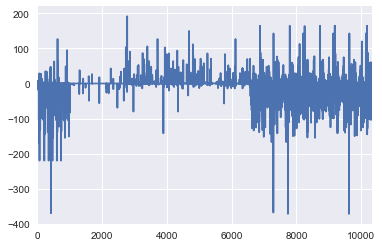

In [70]:
# Checking out the delay column..
delay=pd.to_numeric(ddate['delivery_delay_time'])/(1e9*3600*24)
delay.plot()

In [71]:
#### Engineer the categorical targets:
dobject['delayed'] = ddate['delivery_delay_time']>'0 days'
print("----\nNew delayed column: ", dobject.delayed.value_counts())
print("----\nAverage % of delayed deliveries: ",dobject.delayed.sum()/len(dobject))

----
New delayed column:  False    9138
True     1186
Name: delayed, dtype: int64
----
Average % of delayed deliveries:  0.114877954281


#### Time Series Features
#### *Lagging, rolling statistics, and cumulative*

#### Cumulative statistics, vendor-item level

In [72]:
#- lag variable: last delivery outcome, last delivery days delay
# merge ddate with delayed and delivery_delay_time
# country-item, vendor-item, factory-item
df_trend = pd.concat([ddate[['del_date_client','delivery_delay_time']]
                      , dobject[['itm_desc','vendor', 'factory', 'delayed']]], axis=1)

df_trend['delayed'] = df_trend.delayed.map({True:1, False:0})
df_trend['delivery_delay_time'] = df_trend.delivery_delay_time.dt.days
# Group and sort to get order
dgrp = df_trend.sort_values(by=['del_date_client', 'vendor', 'itm_desc']
        , ascending =True)[['del_date_client', 'vendor'
                            , 'itm_desc', 'delayed', 'delivery_delay_time']].groupby(
    ['del_date_client', 'vendor', 'itm_desc'])
#df_trend, make sure to shift to avoid collinearity!
dcum = dgrp.agg(['cumsum', 'cummin']).shift(+1)
dcum.columns = ['delay_cumsum', 'delay_cummin', 'del_del_time_cumsum', 'days_delay_cummin']
dcum.head()

,delay_cumsum,delay_cummin,del_del_time_cumsum,days_delay_cummin
522,NaN,NaN,NaN,NaN
412,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0
2480,0.0,0.0,0.0,0.0


#### Rolling Statistics

In [73]:
#- rolling sum of delays to date, rolling mean of days delayed
#dcum.head() Sort again for this rolling stats. Shift to avoid multicollinearity
dsorted = df_trend.sort_values(by=['del_date_client', 'vendor', 'itm_desc'])
dsorted['delay_rmean'] = pd.rolling_mean(dsorted.delayed, window=21).shift(+1)
dsorted['days_delay_rmean'] = pd.rolling_mean(dsorted.delivery_delay_time, window=21)
# Merge the dfs together
dtrend = pd.merge(dsorted, dcum, how = 'inner', right_index= True, left_index= True)
# Merge back together and make sure idex is sorted for future concatenation
dtrend = dtrend.drop(['del_date_client', 'delivery_delay_time', 'itm_desc'
                      , 'vendor', 'factory', 'delayed'], axis=1).sort_index()
dtrend.head()

,delay_rmean,days_delay_rmean,delay_cumsum,delay_cummin,del_del_time_cumsum,days_delay_cummin
0,NaN,NaN,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,0.0,0.0,0.0,0.0
3,NaN,NaN,0.0,0.0,0.0,0.0
4,NaN,NaN,0.0,0.0,0.0,0.0


In [74]:
dtrend.fillna(method='bfill', axis=0, inplace=True)
dtrend.isnull().sum()

delay_rmean            0
days_delay_rmean       0
delay_cumsum           0
delay_cummin           0
del_del_time_cumsum    0
days_delay_cummin      0
dtype: int64

### Feature Creation
### External features from other sources

#### *Fragile State Index (FSI) - country stability*

In [75]:
fragility_index = mhf.generate_country_stability_features() #fsi index
print(fragility_index.shape)
fragility_index.head()

(2099, 3)


,fsi,year,country
0,112.3,2006,Sudan
1,110.1,2006,Congo Democratic Republic
2,109.2,2006,Cote d'Ivoire
3,109.0,2006,Iraq
4,108.9,2006,Zimbabwe


#### *Logistics Performance Indices (LPI)*

In [76]:
logistics_indices = mhf.generate_country_logistics_features() #lpi

160
shape ct:  (160, 36)
missing_cols: 42
(1760, 9)
lpi describe:             customs        infra    intl_ship  logistic_qlty          lpi  \
count  1760.000000  1760.000000  1760.000000    1760.000000  1760.000000   
mean      2.652534     2.702813     2.828706       2.799834     2.859719   
std       0.567318     0.660138     0.487789       0.585656     0.550927   
min       1.111111     1.100000     1.222220       1.250000     1.211669   
25%       2.244128     2.233903     2.496660       2.377321     2.464608   
50%       2.579769     2.599128     2.793681       2.727269     2.764329   
75%       2.912981     3.031271     3.123747       3.077599     3.141938   
max       4.207790     4.439356     4.235000       4.315699     4.225967   

        timeliness  track_trace  
count  1760.000000  1760.000000  
mean      3.289748     2.875927  
std       0.553853     0.600903  
min       1.375000     1.000000  
25%       2.893916     2.451238  
50%       3.255500     2.810145  
75%       

In [77]:
lpi_fsi_comparison = mhf.compare_columns(logistics_indices
                    , fragility_index,'country','country') # compare country colums

data1 shape: 160 data2 shape: 178
(196, 2)
36 18
In data2 but not in data1: ['Congo Democratic Republic', "Cote d'Ivoire", 'North Korea', 'Sierra Leone', 'Yemen', 'Uganda', 'Egypt', 'Syria', 'Laos', 'Russia', 'Guinea Bissau', 'Iran', 'Venezuela', 'Israel and West Bank', 'Morocco', 'Macedonia', 'Gambia', 'Albania', 'South Korea', 'Timor-Leste', 'Congo Republic', 'Swaziland', 'Cape Verde', 'Sao Tome and Principe', 'Suriname', 'Samoa', 'Micronesia', 'Grenada', 'Seychelles', 'Brunei Darussalam', 'Belize', 'Trinidad and Tobago', 'Antigua and Barbuda', 'Bahamas', 'Barbados', 'South Sudan'] 
----
In data1 but not in data2: ['Bahamas, The', 'Congo, Dem. Rep.', 'Congo, Rep.', "Côte d'Ivoire", 'Egypt, Arab Rep.', 'Gambia, The', 'Guinea-Bissau', 'Hong Kong SAR, China', 'Israel', 'Korea, Rep.', 'Lao PDR', 'Macedonia, FYR', 'Russian Federation', 'Sco Tomi and Principe', 'Syrian Arab Republic', 'Taiwan', 'Venezuela, RB', 'Yemen, Rep.']


In [78]:
lpi_fsi_combined = mhf.combine_logistics_and_stability_features(
    logistics_indices, fragility_index) # combine logistics (lpi) and fragility (fsi) indices


Country names to harmonize:  ['Afghanistan' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' 'Croatia' 'Cuba'
 'Cyprus' 'Czech Republic' "Côte d'Ivoire" 'Denmark' 'Djibouti'
 'Dominican Republic' 'Ecuador' 'Egypt, Arab Rep.' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'Gabon' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya'
 'Korea, Rep.' 'Kuwait' 'Kyrgyz Republic' 'Lao PDR' 'Latvia' 'L

#### *Factory Location, Country and Continent*

In [81]:
# Generate Factory Metrics. Rerun if you get Index Error, Google's Fault
factory_metrics = mhf.generate_factory_location_features(dobject)

# Alternatively, if generate facotry location is too slow or break
# then use already generated tables from this file below...
#factory_metrics = pd.read_csv('./Data/Features/factory_map_premade.csv')

factory_address: 88 ; factory: 88
Series([], Name: factory_address, dtype: int64) 

The unidentified factories...
 []
factory shape:  (88, 4)
Countries in both origin and destination:  ['South Africa', 'South Africa', 'South Africa']


In [82]:
# Join them to main data (Next Step Depends on this!)
dobject = mhf.add_factory_origin_features(dobject, factory_metrics)

In [83]:
destination_metrics, origin_metrics = mhf.destination_and_origin_lpi_fsi_indicators(
    dobject, lpi_fsi_combined)

Destination countries data:  (219, 5) Unique countries:  ['Afghanistan' 'Angola' 'Belize' 'Benin' 'Botswana' 'Burkina Faso'
 'Burundi' 'Cameroon' 'Congo, DRC' "Côte d'Ivoire" 'Dominican Republic'
 'Ethiopia' 'Ghana' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Kazakhstan'
 'Kenya' 'Kyrgyzstan' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Malawi' 'Mali'
 'Mozambique' 'Namibia' 'Nigeria' 'Pakistan' 'Rwanda' 'Senegal'
 'Sierra Leone' 'South Africa' 'South Sudan' 'Sudan' 'Swaziland' 'Tanzania'
 'Togo' 'Uganda' 'Vietnam' 'Zambia' 'Zimbabwe'] Origin countries data:  (150, 5) Unique countries:  ['Australia' 'Canada' 'China' 'Cyprus' 'France' 'Germany' 'Greece' 'India'
 'Ireland' 'Italy' 'Netherlands' 'Norway' 'Poland' 'Puerto Rico'
 'South Africa' 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'United Kingdom' 'United States']
data1 shape: 43 data2 shape: 178
(181, 2)
138 3
In data2 but not in data1: ['Congo Democratic Republic', "Cote d'Ivoire", 'Iraq', 'Chad', 'Somalia', 'Central African Repu

4          NaN  


In [84]:
# Drop the straggler columns
origin_metrics.drop('country', axis=1, inplace=True)
origin_metrics.drop('year', axis=1, inplace=True)
destination_metrics.drop('year', axis=1, inplace=True)
# Change the columns names for easier tracking
destination_metrics.columns = ["dest_"+x for x in destination_metrics.columns]
origin_metrics.columns = ["orig_"+x for x in origin_metrics.columns]

In [85]:
dobject=mhf.add_lpi_fsi_features(dobject, origin_metrics, destination_metrics) # Must Happen after they are generated!

In [86]:
print(dobject.shape,dobject.columns)

(10324, 88) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
       'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
       'del_date_scheduled_yr', 'del_date_scheduled_mn',
       'del_date_scheduled_dy', 'del_date_client_yr', 'del_date_client_mn',
       'del_date_client_dy', 'del_date_recorded_yr', 'del_date_recorded_mn',
       'del_date_recorded_dy', 'pq_date_new_wd', 'pq_date_new_wk',
       'pq_date_new_qt', 'po_date_new_wd', 'po_date_new_wk', 'po_date_new_qt',
       'del_date_scheduled_wd', 'del_date_scheduled_wk',
       'del_date_scheduled_qt', 'del_date_client_wd', 'del_date_client_wk',
       'del_date_client_qt', 'del_date_recorded_wd', 'del_date_recorded_w

In [87]:
# Look at mean - average rate of delays per country, and correlation with other variables
#mhf.country_metrics_corr(origin_metrics) 

In [88]:
# Look at mean - average rate of delays per country, and correlation with other variables
#mhf.country_metrics_corr(destination_metrics) # Look at mean

### Save the blocks of data separately in *"Data/Features"* folder
#### *To be uploaded in next NoteBook - EDA and Feature Selection*

In [89]:
# Fill the nulls
nullc = dobject.isnull().sum()[dobject.isnull().sum()>0].index.tolist()
for c in nullc:
    try:
        cmean = dobject[c].mean()
        dobject[c].fillna(cmean, inplace=True)
    except:
        pass
# Split the numerical columns from dobject to separate df
dobject['delayed'] = pd.Categorical(dobject.delayed)
mainblocks = mhf.get_blocks_by_dtype(dobject)
# Convert to categorical
for c in mainblocks['object']:
    mainblocks['object'][c] = pd.Categorical(mainblocks['object'][c])
# Do the do_purch, do_del split here as well
mainblocks.keys()

Total Number of Columns: 88
Breakdown....

Type: category , Count: 30 
Columns and null counts---: 
pq_date_new_yr           0
pq_date_new_mn           0
pq_date_new_dy           0
po_date_new_yr           0
po_date_new_mn           0
po_date_new_dy           0
del_date_scheduled_mn    0
del_date_scheduled_dy    0
del_date_client_yr       0
del_date_client_mn       0
del_date_client_dy       0
del_date_recorded_yr     0
del_date_recorded_mn     0
del_date_recorded_dy     0
pq_date_new_wd           0
pq_date_new_wk           0
pq_date_new_qt           0
po_date_new_wd           0
po_date_new_wk           0
po_date_new_qt           0
del_date_scheduled_wd    0
del_date_scheduled_wk    0
del_date_scheduled_qt    0
del_date_client_wd       0
del_date_client_wk       0
del_date_client_qt       0
del_date_recorded_wd     0
del_date_recorded_wk     0
del_date_recorded_qt     0
delayed                  0
dtype: int64

Type: float64 , Count: 20 
Columns and null counts---: 
dest_sum            

dict_keys(['category', 'float64', 'int64', 'object'])

In [90]:
dnum_country.head()

,country,factory,vendor,molecule_test,brand,del_date_scheduled_yr,country_qtysum,country_qtycount,country_qtymean,country_valsum,...,country_valmean,country_inssum,country_inscount,country_insmean,country_weightsum,country_weightcount,country_weightmean,country_costsum,country_costcount,country_costmean
0,Côte d'Ivoire,Ranbaxy Fine Chemicals LTD,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,2006,29553,14,2110.928571,370713.7,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,941845.702504,14,67274.693036
1,Côte d'Ivoire,ABBVIE GmbH & Co.KG Wiesbaden,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,2006,29553,14,2110.928571,370713.7,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,941845.702504,14,67274.693036
2,Côte d'Ivoire,Bio-Rad Laboratories,BIO-RAD LABORATORIES (FRANCE),"HIV, Genie II HIV-1/HIV-2 Kit",Genie,2006,29553,14,2110.928571,370713.7,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,941845.702504,14,67274.693036
3,Côte d'Ivoire,"Pacific Biotech, Thailand",Orasure Technologies Inc.,"HIV 1/2, OraQuick Advance HIV Rapid Antibody Kit",OraQuick,2006,29553,14,2110.928571,370713.7,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,941845.702504,14,67274.693036
4,Côte d'Ivoire,Bio-Rad Laboratories,BIO-RAD LABORATORIES (FRANCE),"HIV, Genie II HIV-1/HIV-2 Kit",Genie,2006,29553,14,2110.928571,370713.7,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,941845.702504,14,67274.693036


In [91]:
entities =['country', 'factory', 'vendor', 'brand', 'molecule_test']
# Drop redundant columns in 
for d in [dnum_country, dnum_factory, dnum_vendor, dnum_brand, dnum_molecule_test]:
    try:
        d.drop(entities, axis=1, inplace=True)
    except:
        pass
# Make columns index
c=['country_qtycount']+[c for c in dnum_country.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
v=['vendor_qtycount']+[c for c in dnum_vendor.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
f=['factory_qtycount']+[c for c in dnum_factory.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
b=['brand_qtycount']+[c for c in dnum_brand.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
m=['molecule_test_qtycount']+[c for c in dnum_molecule_test.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
# Drop duplicate columns for counts
dnum_country, dnum_vendor, dnum_factory,dnum_brand, dnum_molecule_test = dnum_country[c],dnum_vendor[v], dnum_factory[f],dnum_brand[b],dnum_molecule_test[m]

In [92]:
# Merge the categorical elements
dobject = pd.concat([mainblocks['category'],mainblocks['object']], axis=1)
# Merge the new numerical festures
dnum_lpifsi = pd.concat([mainblocks['float64'], mainblocks['int64']],axis=1)
# Make lists for the save loop
dchunks = [dnum,dnum_country, dnum_vendor,dnum_factory, dnum_brand
           ,dnum_molecule_test,dnum_lpifsi,ddate, dobject, dtrend]
dnames = ['dnum','dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand'
          , 'dnum_molecule_test','dnum_lpifsi', 'ddate', 'dobject', 'dtrend']
import datetime as dt
import os
for i in range(len(dnames)):
    fn= "_"+str(i)+"_"+dnames[i]+".csv"
    path= os.curdir+'\Data\Features\\'
    print(fn)
    dchunks[i].to_csv(path+fn)

_0_dnum.csv
_1_dnum_country.csv
_2_dnum_vendor.csv
_3_dnum_factory.csv
_4_dnum_brand.csv
_5_dnum_molecule_test.csv
_6_dnum_lpifsi.csv
_7_ddate.csv
_8_dobject.csv
_9_dtrend.csv


---
# **CheckPoint 1**
### Next Section: Exploratory Data Analysis & Feature Selection
---